## Demo of Variational Autoencoders

This is a basic demo of variational autoencoders on MNIST data using TensorFlow and Keras, adapted from the post [Variational AutoEncoders and Image Generation with Keras](https://dropsofai.com/variational-autoencoders-and-image-generation-with-keras/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import tensorflow
tensorflow.compat.v1.disable_eager_execution()

### Load data and display a few images

Training data shape: X=(60000, 28, 28), y=(60000,)
Testing data shape: X=(10000, 28, 28), y=(10000,)


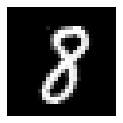

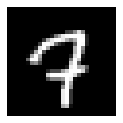

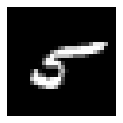

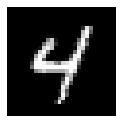

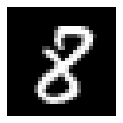

In [3]:
from tensorflow.keras.datasets import mnist

(trainX, trainy), (testX, testy) = mnist.load_data()

print('Training data shape: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Testing data shape: X=%s, y=%s' % (testX.shape, testy.shape))

ind = np.random.choice(np.arange(len(trainX)), size=5)
for i in ind:
    plt.figure(figsize=(2, 2))
    plt.imshow(trainX[i], cmap='gray')
    plt.axis('off')
    plt.title('')
plt.show()

### Reshape the data to have one channel

In [4]:
train_data = trainX.astype('float32')/255
test_data = testX.astype('float32')/255

train_data = np.reshape(train_data, (60000, 28, 28, 1))
test_data = np.reshape(test_data, (10000, 28, 28, 1))


# Building the VAE

### Encoder network

This is the network that outputs the variational mean and variance. It has three convolutional layers and a dense layer.


In [5]:
import tensorflow

input_data = tensorflow.keras.layers.Input(shape=(28, 28, 1))

encoder = tensorflow.keras.layers.Conv2D(64, (5,5), activation='relu')(input_data)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Conv2D(64, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Conv2D(32, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Flatten()(encoder)
encoder = tensorflow.keras.layers.Dense(16)(encoder)

### Sampling from the variational distribution

This applies the "reparameterization trick" by sampling a standard Gaussian, scaling by the noise level and adding the mean:

$$ Z  = \mu(x) + \sigma(x) \epsilon$$

Since the network outputs the log of the variance, we exponentiate it:

$$ \sigma(x) = \exp\left(\frac{1}{2} \log \sigma^2(x)\right)$$

In [6]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tensorflow.shape(distribution_variance)[0]
    random = tensorflow.keras.backend.random_normal(shape=(batch_size, tensorflow.shape(distribution_variance)[1]))
    return distribution_mean + tensorflow.exp(0.5 * distribution_variance) * random

In [7]:
distribution_mean = tensorflow.keras.layers.Dense(2, name='variational_mean')(encoder)
distribution_variance = tensorflow.keras.layers.Dense(2, name='variational_log_variance')(encoder)
latent_encoding = tensorflow.keras.layers.Lambda(sample_latent_features)([distribution_mean, distribution_variance])

In [8]:
encoder_model = tensorflow.keras.Model(input_data, latent_encoding)
encoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 24, 24, 64)   1664        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 12, 12, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 10, 10, 64)   36928       max_pooling2d[0][0]              
______________________________________________________________________________________________

## Generative network or decoder

In [9]:
decoder_input = tensorflow.keras.layers.Input(shape=(2))
decoder = tensorflow.keras.layers.Dense(64)(decoder_input)
decoder = tensorflow.keras.layers.Reshape((1, 1, 64))(decoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)

decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)

decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)

decoder_output = tensorflow.keras.layers.Conv2DTranspose(1, (5,5), activation='relu')(decoder)

In [10]:
decoder_model = tensorflow.keras.Model(decoder_input, decoder_output)
decoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                192       
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 3, 3, 64)          36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 5, 5, 64)          36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 12, 12, 64)        3692

## Combining

In [11]:
encoded = encoder_model(input_data)
decoded = decoder_model(encoded)

In [12]:
autoencoder = tensorflow.keras.models.Model(input_data, decoded)

### Loss Function (Reconstruction Loss + KL-loss)

As not mentioned in class, when generating data, we can add noise. Thus the model is 
$ Z \sim N(0,I)$ and then $X | z = N(G(z), \gamma^2 I)$ where the noise level is $\gamma$.
In this case we add a mean-squared error term to the loss function. And MSE minus ELBO is MSE + KL(q, p).

In [13]:
def get_loss(distribution_mean, distribution_variance):
    
    def get_reconstruction_loss(y_true, y_pred):
        reconstruction_loss = tensorflow.keras.losses.mse(y_true, y_pred)
        reconstruction_loss_batch = tensorflow.reduce_mean(reconstruction_loss)
        return reconstruction_loss_batch*28*28
    
    def get_kl_loss(distribution_mean, distribution_variance):
        kl_loss = 1 + distribution_variance - tensorflow.square(distribution_mean) - tensorflow.exp(distribution_variance)
        kl_loss_batch = tensorflow.reduce_mean(kl_loss)
        return kl_loss_batch*(-0.5)
    
    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
        return reconstruction_loss_batch + kl_loss_batch
    
    return total_loss

## Training

In [14]:
autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance), optimizer='adam')
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model (Functional)           (None, 2)                 57652     
_________________________________________________________________
model_1 (Functional)         (None, 28, 28, 1)         112577    
Total params: 170,229
Trainable params: 170,229
Non-trainable params: 0
_________________________________________________________________


In [16]:
autoencoder.fit(train_data, train_data, epochs=10, batch_size=64, validation_data=(test_data, test_data))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 85s 1ms/sample - loss: 42.6096 - val_loss: 39.7840
Epoch 2/10
60000/60000 [==============================] - 83s 1ms/sample - loss: 37.9426 - val_loss: 36.9751
Epoch 3/10
60000/60000 [==============================] - 80s 1ms/sample - loss: 36.7978 - val_loss: 37.9828
Epoch 4/10
60000/60000 [==============================] - 83s 1ms/sample - loss: 36.2316 - val_loss: 36.2730
Epoch 5/10
60000/60000 [==============================] - 86s 1ms/sample - loss: 35.7450 - val_loss: 35.3682
Epoch 6/10
60000/60000 [==============================] - 84s 1ms/sample - loss: 35.4566 - val_loss: 35.7985
Epoch 7/10
60000/60000 [==============================] - 84s 1ms/sample - loss: 35.1659 - val_loss: 35.0202
Epoch 8/10
60000/60000 [==============================] - 83s 1ms/sample - loss: 34.9115 - val_loss: 35.0072
Epoch 9/10
60000/60000 [==============================] - 85s 1ms/sample - los

Real Test Images


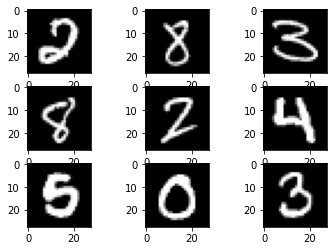

Reconstructed Images with Variational Autoencoder


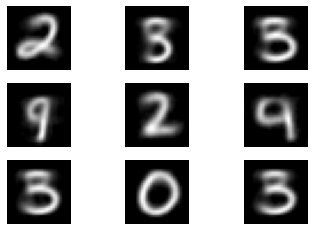

In [17]:
offset=400
print ("Real Test Images")
# Real Images
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(test_data[i+offset,:,:, -1], cmap='gray')
plt.show()

# Reconstructed Images
print ("Reconstructed Images with Variational Autoencoder")
for i in range(9):
    plt.subplot(330 + 1 + i)
    output = autoencoder.predict(np.array([test_data[i+offset]]))
    op_image = np.reshape(output[0]*255, (28, 28))
    plt.imshow(op_image, cmap='gray')
    plt.axis('off')
plt.show()

## Latent feature clusters

In [18]:
x = []
y = []
z = []
for i in range(10000):
    z.append(testy[i])
    op = encoder_model.predict(np.array([test_data[i]]))
    x.append(op[0][0])
    y.append(op[0][1])

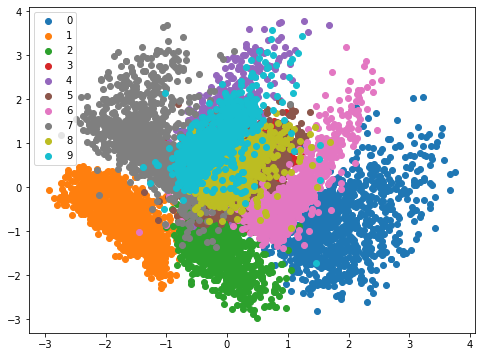

In [19]:
df = pd.DataFrame()
df['x'] = x
df['y'] = y
df['z'] = ["digit-"+str(k) for k in z]
plt.figure(figsize=(8, 6))
for c in np.unique(z):
    i = np.where(z == c)
    plt.scatter(np.array(x)[i], np.array(y)[i], label=c)
plt.legend()
plt.show()

## Image Generation

In [20]:
generator_model = decoder_model

In [21]:
x_values = np.linspace(-3, 3, 30)
y_values = np.linspace(-3, 3, 30)

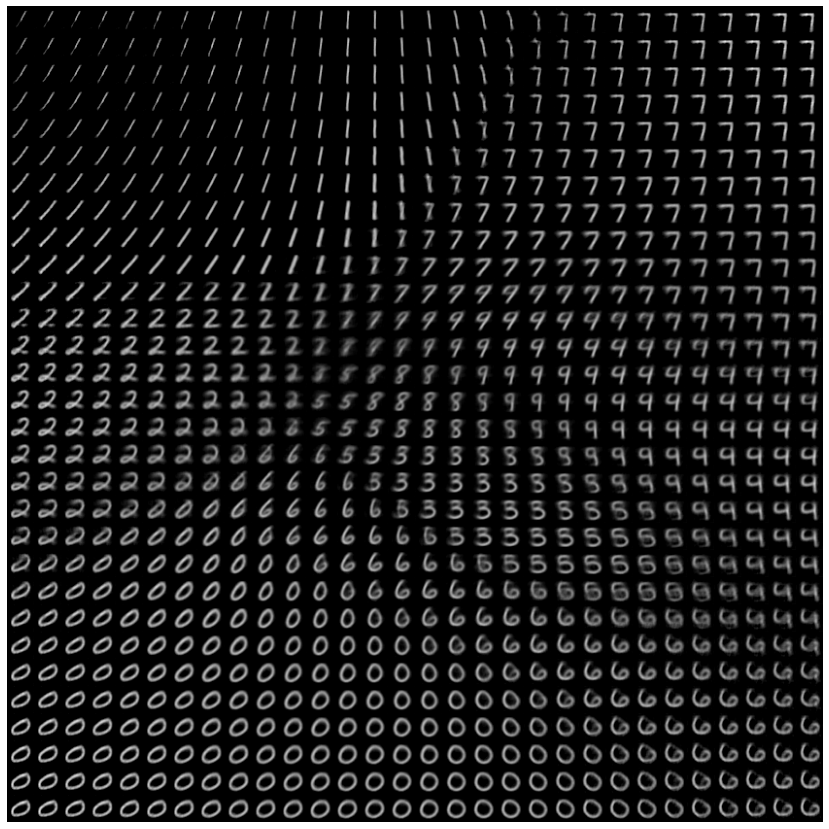

In [22]:
figure = np.zeros((28 * 30, 28 * 30))
for ix, x in enumerate(x_values):
    for iy, y in enumerate(y_values):
        latent_point = np.array([[x, y]])
        generated_image = generator_model.predict(latent_point)[0]
        figure[ix*28:(ix+1)*28, iy*28:(iy+1)*28,] = generated_image[:,:,-1]
 
plt.figure(figsize=(15, 15))
plt.imshow(figure, cmap='gray', extent=[3,-3,3,-3])
plt.axis('off')
plt.show()